## Rudimentary Avian Magnetoreceptive Navigation Model


#### Original Project Proposal:
BIOL 487 Computational Neuroscience Project Outline – J. Romero (20806791) – Winter 2024

Preface: 

My interest in the subject matter of this project began when I wrote condensed literature review paper in PHYS 380 (Molecular and Cellular Biophysics) at UW in 2021. The paper was titled: *Avian Magnetoreception Navigation Systems - A Biophysical Marvel*. In the condensed review paper I discuss the hypothesized mechanism for magnetoreception according to literature. There are really 2 main magnetoreception mechanisms:

- The retinal radical pair mechanism,
- and the magnetite-based dendritic receptor in the upper beak.

Both mechansims are explored in this project. To faclicitate and simplify the experimentation and analysis, we can consider 2- dimensional representation of the 3-dimensional system discussed in my paper. We start by modelling the magnetic field using vector field. 

As a brief aside, we show that a bird can plausibly reorient itself to point in the direction of the magnetic field using a winner-take-all synapse model.

Then we create a bird class with a retina that is modelled as a 3-point line segment perpendicular to the bird's pointed direction in the magnetic field where the flux of the field at any point on the retina is proportional to the dot product to the magnetic field, this is effectively a flux value. These three flux values serve as a magnetic 'image' that is used to model a neural network capable of providing the home direction. It's important to note that the retinal model is not the only input, as it provides no information on magnetic field strength. Thus, the magnetic field strength, at the birds location is also of relevance. The goal of the neural network, is to determine the direction the bird would need to face to point to their home point (assuming they are capable of orienting in the direction of the magnetic field)


##### Creating a magnetic field representation in 2-dimensions

We start by defining a function that can generate a vector field to represent the magnetic field in 2 dimensions.

We can consider a simple magnetic field which which points north at all points in 2-dimensional space. In this case the equation for the magnetic field vector at any point is:

$ \vec{B} = B_0 * \hat{j}$

Where $B_0$ is the strength of the magnetic field at any given point as it is uniform at all points in space and $\hat{j}$ is a unit vector pointing north.

However, this vector field does not provide a lot of information about location. To aid in this, we can model the magnetic field as a non-uniform vector field that converges at points closer to the north pole. In this case, the vector field is given by:

$ \vec{B}(x, y) = (B_0  + \alpha*y)\hat{j} - (\beta * y * \frac{x}{|x|})\hat{i} $

Where $ \alpha $ determines the rate at which the magnetic field increases with increasing y and $ \beta $ determines the rate at which the magnetic field lines converge with increasing y.

Lastly, we take add an x-dependance to the $\hat{i}$ component so that there is variability in the x-axis beyond defining the left or right side of the y-axis.

$ \vec{B}(x, y) = (B_0  + \alpha*y)\hat{j} - (\beta * y * \frac{x}{|x|} * (X_{dependance} * x))\hat{i} $

We create our magnetic field adding complexity with each step, ending with a call to the magnetic field representaton class that will be used in he project.


In [2]:
from scipy.interpolate import griddata
import numpy as np
import matplotlib.pyplot as plt

In [3]:
## We define a class that represents a 2D magnetic field.
## Note that in order to map a the earth's spherical surface onto a 2D plane, we include the x component's depedence on x which causes
## variablity in the magnetic field along the x axis. This simply accounts for the fact that the bird is not at the centre line at
## all times.
class magnetic_field_2D:
    def __init__(self, B_not, alpha, beta, x_min, x_max, y_min, y_max, x_dependance=0.01):
        self.B_not = B_not
        self.alpha = alpha
        self.beta = beta
        self.x_min = x_min
        self.x_max = x_max
        self.y_min = y_min
        self.y_max = y_max
        self.x_dependance = x_dependance

        ## We create a 2D magnetic field representation at initialization.
        self.mag_field_space = self._mag_field_create()

    ## We define function for the 2D represenation of the magnetic field.
    ##  Note: This function is NOT a plane in 3D space with a magnetic field.
    ##        It is a 2D representation of the magnetic field that resembles a 3D magnetic field.
    def _2D_magnetic_field_represenation(self, x, y):
        y_component = (self.B_not + self.alpha * y)
        x_component = -(self.beta * y * (self.x_dependance * x))  ## Note the x component is now dependent on x
        return x_component, y_component

    ## Define a function to create a 2D magnetic field representation at initialization.
    def _mag_field_create(self):
        x = np.linspace(self.x_min, self.x_max, 20)
        y = np.linspace(self.y_min, self.y_max, 20)
        X, Y = np.meshgrid(x, y)
        Bx, By = self._2D_magnetic_field_represenation(X, Y)
        return ([X, Y], [Bx, By])

    def mag_field_interpolate(self, x, y):
        assert x >= self.x_min and x <= self.x_max, "x value out of range"
        assert y >= self.y_min and y <= self.y_max, "y value out of range"

        # Coordinates of the magnetic field space
        X = self.mag_field_space[0][0]
        Y = self.mag_field_space[0][1]

        # Magnetic field components
        B_x = self.mag_field_space[1][0]
        B_y = self.mag_field_space[1][1]

        # Interpolating the magnetic field components
        B_y_i = griddata((X.flatten(), Y.flatten()), B_y.flatten(), (x, y), method='cubic')
        B_x_i = griddata((X.flatten(), Y.flatten()), B_x.flatten(), (x, y), method='cubic')

        return B_x_i, B_y_i
    
    def plot_magnetic_field(self):
        X = self.mag_field_space[0][0]
        Y = self.mag_field_space[0][1]
        B_x = self.mag_field_space[1][0]
        B_y = self.mag_field_space[1][1]
        plt.figure()
        plt.quiver(X, Y, B_x, B_y)
        plt.title('2D Magnetic Field Representation')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.show()
    
    def __str__(self) -> str:
        return f"2D magnetic field representation with B_not={self.B_not}, alpha={self.alpha}, beta={self.beta} and x_dependance={self.x_dependance}"
    
    def destroy(self):
        del self


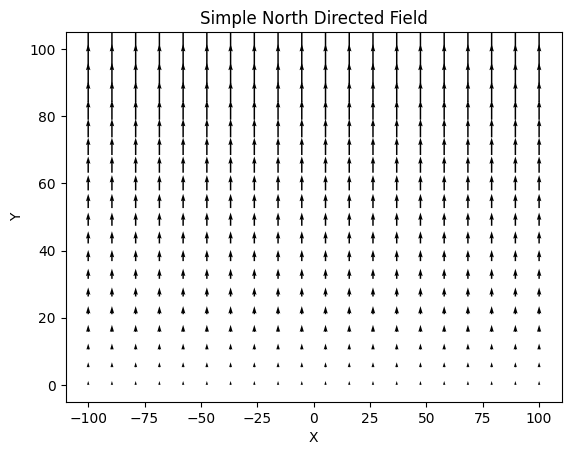

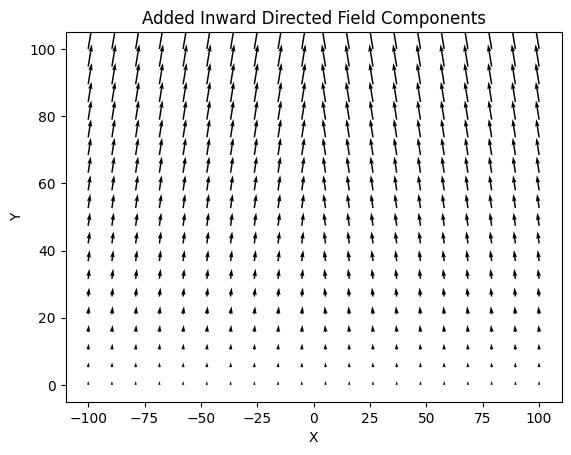

2D magnetic field representation with B_not=5, alpha=0.1, beta=0.02 and x_dependance=0.03


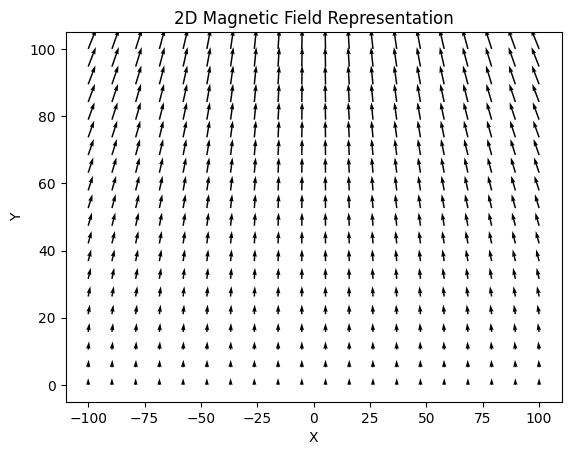

In [4]:
## We define a magnetic field as shown above, which portrays what at the centre line (x = 0) may experience. 
def mag_field_point(x, y, B_not, alpha, beta):
    y_component = (B_not + alpha * y)
    x_component = -(beta * y * np.sign(x))

    return [x_component, y_component]

## Let's create a plot to visualize the magnetic field
# Define the range of x and y values
x = np.linspace(-100, 100, 20)
y = np.linspace(0, 100, 20)

# Create a meshgrid of x and y values
X, Y = np.meshgrid(x, y)

# Calculate a basic magnetic vector field where the field at all points is directed towards north.
U1, V1 = mag_field_point(X, Y, B_not=2, alpha=0.1, beta=0)

# Calculate the magnetic field vectors that point inward towards the centre line.
U2, V2 = mag_field_point(X, Y, B_not=2, alpha=0.1, beta=0.02)

# Plotting simple north directed field.
plt.figure()
plt.quiver(X, Y, U1, V1)
plt.title('Simple North Directed Field')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# Plotting inward directed field.
plt.figure()
plt.quiver(X, Y, U2, V2)
plt.title('Added Inward Directed Field Components')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

## No we can use the magnetic_field_2D class to create a 2D magnetic field representation.
##  Note The key difference here is he the x component is dependent on x, which causes the
##  magnetic field to vary along the x axis. This is done to account for the fact that the 
##  bird is not at the centre line at all times. In a 3D representation, the magnetic field
##  would be uniform along the x axis (which would be the latitudinal axis in a 3D representation).
mag_field = magnetic_field_2D(B_not=5, alpha=0.1, beta=0.02, x_min=-100, x_max=100, y_min=0, y_max=100, x_dependance=0.03)
print(mag_field)
mag_field.plot_magnetic_field()
mag_field.destroy()

Above we can see that its somewhat challenging to model the differential nature of a 3-dimensional magnetic field in 2 dimensions but it can be accomplished with some fidelity. I'll note that the earths magnetic field varies in all 3 dimentions dependant on the the 3-dimensional position on the earth. That is, at the equator it is weaker and more simply directed northward but as one approaches the equator, the downward (or earthward) incliation of the field begins to gain more relevance and likely provide important queues in migrational navigation.

##### Defining our bird (class)

The bird class is defined in a realtively standard way. A bird has a position and direction. The bird also has a retina model that is defined as a 3-point perpendicular line segment placed slightly ahead of the bird's centre point. The mag_view method can interpolate the magnetic field at the three retinal model points by taking the dot product to obtain 3 flux values. These flux values are then normalize and serve as a magnetic image from the bird's perspective in their position and direction.

In [6]:
import numpy as np

## Bird class
class Bird:
    def __init__(self, position, direction):
        self.position = [position[0], position[1]] ## x, y
        self.direction = direction ## NOTE Angle in radians from the positive x-axis

    # Move the bird by a certain distance
    def move(self, distance):
        self.position[0] += distance * np.cos(self.direction)
        self.position[1] += distance * np.sin(self.direction)

    # Rotate the bird by a certain angle
    def rotate(self, angle):
        self.direction += angle
    

    def move_to_position(self, position, direction=None):
        self.position = position
        if direction is not None:
            self.direction = direction

    # The bird's retina model for 3 points at its current position and direction
    def bird_view_points(self):
        bird_position = self.position
        bird_direction = self.direction

        # Calculate displacement vector
        dx = 0.1 * np.cos(bird_direction)
        dy = 0.1 * np.sin(bird_direction)

        # Calculate coordinates of the first point
        x1 = bird_position[0] + dx
        y1 = bird_position[1] + dy

        # Calculate displacement vectors for the other two points
        dx1 = 0.2 * np.cos(bird_direction + np.pi/2)
        dy1 = 0.2 * np.sin(bird_direction + np.pi/2)
        dx2 = 0.2 * np.cos(bird_direction - np.pi/2)
        dy2 = 0.2 * np.sin(bird_direction - np.pi/2)

        # Calculate coordinates of the second point
        x2 = x1 + dx1 + 0.5 * dx
        y2 = y1 + dy1 + 0.5 * dy

        # Calculate coordinates of the third point
        x3 = x1 + dx2 + 0.5 * dx
        y3 = y1 + dy2 + 0.5 * dy

        p1 = [x1, y1]
        p2 = [x2, y2]
        p3 = [x3, y3]

        return p1, p2, p3 # Return the 3 points, where the centre point is p1
        # # Print the coordinates of the three points
        # print("Point 1: ({}, {})".format(x1, y1))
        # print("Point 2: ({}, {})".format(x2, y2))
        # print("Point 3: ({}, {})".format(x3, y3))

    # Bird's magnetic field using the 3-point retina model from above
    def bird_magview(self, mag_field):
        p1, p2, p3 = self.bird_view_points()

        # Reminder that p1 is the centre point
        B1 = mag_field.mag_field_interpolate(p1[0], p1[1])
        B2 = mag_field.mag_field_interpolate(p2[0], p2[1])
        B3 = mag_field.mag_field_interpolate(p3[0], p3[1])

        # Magnetic fields are dotted with the displacement vectors to get the magnetic flux
        flux1 = np.dot(B1, [np.cos(self.direction), np.sin(self.direction)])
        flux2 = np.dot(B2, [np.cos(self.direction), np.sin(self.direction)])
        flux3 = np.dot(B3, [np.cos(self.direction), np.sin(self.direction)])

        return flux1, flux2, flux3
   
    def __str__(self):
        return "Bird at position ({}, {}) facing {} degrees".format(self.position[0], self.position[1], self.direction)
    
    def destroy(self):
        del self
    


Next we define a few helper functions to manage the randomized and/or geometric components of the data-generation function which is defined as well.

Thew data generation function does the following:
- Generates a random home point
- Iterates for all of the samples to:
    - Place a bird at a random spot (oriented in the direction of the magnetic field at that point)
    - Records its position, direction, normalized magnetic image, normalized field strength, the computed turn angle require to face the home point
- Lastly it returns the home point as well as the recorded values in a tuple.

In [7]:
import random
import numpy as np

## A function that generates a random bird's position within a given range.
def generate_bird_position(x_min, x_max, y_min, y_max):
    x = random.uniform(x_min, x_max)
    y = random.uniform(y_min, y_max)
    return [x, y]


## A function that generates a random bird's direction within a given range, in radians.
def generate_bird_direction():
    return random.uniform(0, np.pi*2)


## A function that returns the turn angle the bird must make to face the home point in radians.
def bird_turn_to_home(current_direction, current_position, home_point):
    # calculate the direction angle in radians
    direction_rad = np.arctan2(home_point[1] - current_position[1], home_point[0] - current_position[0])
    
    # calculate the turn angle in radians
    turn_rad_unnormalized = direction_rad - current_direction

    bird_turn_rad = (turn_rad_unnormalized + np.pi) % (2 * np.pi) - np.pi
    
    assert bird_turn_rad >= -np.pi and bird_turn_rad <= np.pi, "Turn angle is not within -pi and pi"

    return bird_turn_rad


## generate_training_data
## Input: n_samples, x_min, x_max, y_min, y_max, mag_field_func
## Generates a random home point,
##   then n random bird positions with direction vectors for n samples
##   calculates the direction the bird must travel in order to reach the home point
##   and returns the training data as a list of tuples
def generate_training_data(n_samples, x_min, x_max, y_min, y_max, mag_field_space):
    home_point = generate_bird_position(x_min, x_max, y_min, y_max)
    
    # training_data = []
    points = []
    directions = []
    mag_images_unnormalized = []
    mag_vector_lengths = []
    turn_to_home_thetas = [] # List for turn angles normalized between -pi and pi

    # Data creation loop (does not normalize the magnetic field picture)
    for _ in range(n_samples):
        # Random spot generated with a 1 unit margin from the edges (to avoid edge cases from retina model)
        rand_spot = generate_bird_position(x_min=(x_min + 1), x_max=(x_max - 1), y_min=(y_min + 1), y_max=(y_max - 1))
        # Magnetic field at the random spot (this assumes the bird has already oriented itself in the direction of the magnetic field)
        mag_field_vector = mag_field_space.mag_field_interpolate(rand_spot[0], rand_spot[1])

        # Magnetic field magnitude at the random spot (as sensed by beak magnetite receptors)
        mag_field_magnitude = np.linalg.norm(mag_field_vector)
        mag_vector_lengths.append(mag_field_magnitude)

        bird_position = rand_spot # Place the bird at the random spot
        bird_direction = np.arctan2(mag_field_vector[1], mag_field_vector[0]) # Bird faces the magnetic field

        # Append the random spot and direction to the points and directions lists
        points.append(bird_position)
        directions.append(bird_direction)

        # Create a bird at the random point and direction, then
        #  check it's magnetic view at that point to be stored.
        bird = Bird(bird_position, bird_direction) # Create a bird at the random spot and facing the magnetic field
        flux1, flux2, flux3 = bird.bird_magview(mag_field_space) # Magnetic field image (flux values) at the bird's retina
        bird.destroy()

        # Append the unnormalized magnetic field picture to a temporary list
        mag_image = [flux1, flux2, flux3] # Unnormalized magnetic field picture
        mag_images_unnormalized.append(mag_image)    
        
        # Calculate the turn angle the bird must make to face the home point
        turn_to_home_theta_in_radians = bird_turn_to_home(bird_direction, bird_position, home_point)
        # # Normalize the turn angle to between -1 and 1
        # turn_to_home_theta_normalized = turn_to_home_theta_in_radians / np.pi
        # Append the normalized turn angle to the list
        turn_to_home_thetas.append(turn_to_home_theta_in_radians)
        
    # Normalize the magnetic field picture using the min-max normalization
    ## First create a long 1-dimensional list of the flux values
    ##   Remembering that every triplet along the line is one image
    mag_images_unnormalized_1D = []
    for image in mag_images_unnormalized:
        for flux in image:
            mag_images_unnormalized_1D.append(flux)

    ## Find the max and min values of the flux values and apply min-max normalization
    max_val = max(mag_images_unnormalized_1D)
    min_val = min(mag_images_unnormalized_1D)
    mag_images_normalized = []
    for flux_value in mag_images_unnormalized_1D:
        # Normalize the flux values to between -1 and 1
        normalized_flux_value = (((flux_value - min_val) / (max_val - min_val)) * 2) - 1
        mag_images_normalized.append(normalized_flux_value)
    # Reshape the normalized magnetic field pictures to their original shape (array of 3 arrays)
    mag_images_normalized = np.array(mag_images_normalized).reshape(n_samples, 3)

    # Notmalize the magnetic field strengths using min-max normalization
    max_strength = max(mag_vector_lengths)
    min_strength = min(mag_vector_lengths)
    mag_strengths_normalized = []
    for strength in mag_vector_lengths:
        normalized_strength = 0 + ((strength - min_strength) / (max_strength - min_strength)) * (3 - 0) # Normalize to between a = 0 and b = 3
        mag_strengths_normalized.append(normalized_strength)

    return home_point, (points, directions, mag_images_normalized, mag_strengths_normalized, turn_to_home_thetas)



We have found that, in order the model to be able to learn the home direction, setting the bird's position randomly is not possible. Thus, we can orient the birds in the directiuon of the magnetic field, an take a moment to show how this is plausible with a synapse winner-take-all action model to catagorically determine direction that most points along the magnetic field vector lines.

[0.8533997253619894, 0.49949542446826206, 0.14609577869860185, 0.0, 0.1462930062433992, 0.49949556263486244, 0.8532024760825699, 1.0]  before
[0. 0. 0. 0. 0. 0. 0. 1.]  after synapse
[0. 0. 0. 0. 0. 0. 0. 1.]  target
Correct!
[0.746690203184711, 0.49956412218153967, 0.2528787320854782, 0.1508533758303009, 0.2529156695605631, 0.4995641886727562, 0.746653282353667, 0.8491562022254955]  before
[0.1609251  0.         0.         0.         0.         0.
 0.16086763 0.71954409]  after synapse
[0. 0. 0. 0. 0. 0. 0. 1.]  target
Incorrect!
[0.718825882255533, 0.49958347842602546, 0.28076825273394235, 0.19023895970437402, 0.2807426215883703, 0.4995833654333518, 0.718851480321408, 0.8097824347409723]  before
[0.21036969 0.         0.         0.         0.         0.
 0.21040954 0.65496923]  after synapse
[0. 0. 0. 0. 0. 0. 0. 1.]  target
Incorrect!
[0.6203870023497652, 0.4996717091147071, 0.3792868367966034, 0.32949680033623396, 0.37925616276976754, 0.49967170107808667, 0.6204176667982813, 0.6705

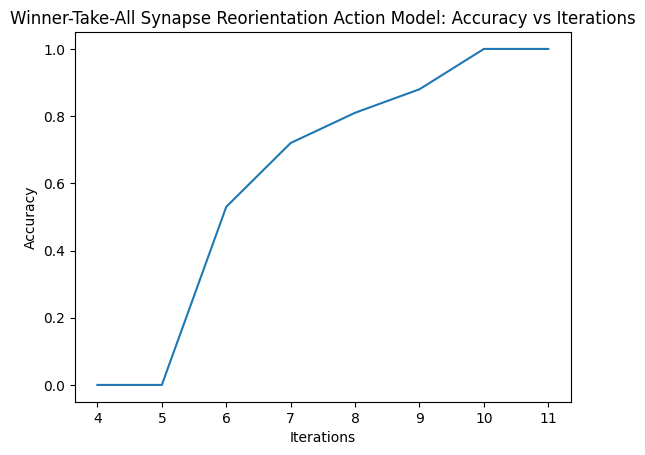

In [8]:
# ## Let's generate a small set of training data
mag_field = magnetic_field_2D(B_not=5, alpha=0.1, beta=0.02, x_min=-100, x_max=100, y_min=0, y_max=100, x_dependance=0.03)
dataset_reorientation_problem = generate_training_data(100, x_min=-100, x_max=100, y_min=0, y_max=100, mag_field_space=mag_field)

## Now we generate a set of test data by placing a bird at the spot
## already generated, rotating them and then checking
## the magnetic field (with) a 1-point retina model) in 8 intervals
## as the bird rotates.
def generate_bird_reorientation_check_data(mag_field_space, bird_positions, bird_starting_directions):
    bird_reorientation_data = []
    for bird in range(len(bird_positions)):
        bird_position = bird_positions[bird]
        bird_direction = bird_starting_directions[bird]
        bird = Bird(bird_position, bird_direction)
        bird_reorientation_checks = []
        for i in range(8):
            bird.rotate(np.pi / 4)
            centre_flux, _, _ = bird.bird_magview(mag_field_space)
            bird_reorientation_checks.append(centre_flux)
        bird.destroy()
        bird_reorientation_data.append(bird_reorientation_checks)

    # print(bird_reorientation_data)

    ## Normalize the bird reorientation data between 0 and 1 (for the sake of the winner-takes-all model)
    max_val = max([max(flux) for flux in bird_reorientation_data])
    min_val = min([min(flux) for flux in bird_reorientation_data])
    bird_reorientation_data_normalized = []
    for flux_values in bird_reorientation_data:
        normalized_flux_values = []
        for flux in flux_values:
            normalized_flux = (flux - min_val) / (max_val - min_val)
            normalized_flux_values.append(normalized_flux)
        bird_reorientation_data_normalized.append(normalized_flux_values)
    
    # print(bird_reorientation_data_normalized)

    return bird_reorientation_data_normalized



## Generate the test data
bird_reorientation_test_data = generate_bird_reorientation_check_data(mag_field, dataset_reorientation_problem[1][0], dataset_reorientation_problem[1][1])


## Now we can create a winner-takes-all-synapse model to postulate that the bird is able always able to reorient itself
## to face the magnetic field by comparing the magnetic field strength at the centre point of the retina model.
def winner_take_all_synapse(N, test_dataset, iterations, inhibition=-0.9, excitation=1, time_constant=0.010, timestep=0.001):
    tau = time_constant # Synapse time constant
    dt = timestep # Timestep
    alpha = 1-np.exp(-dt/tau)

    ## Weight matrix defaults as before
    w = np.zeros((N,N))
    w[:] = inhibition   # set the inhibition amount everywhere
    for i in range(N):
        w[i,i] = excitation   # set the excitatory connection

    record = []   # for recording the activity values
    correct = 0   # for counting the number of correct outputs

    for i in test_dataset:
        print(i, " before")

        # Synapse loop
        activity = np.zeros(N)
        activity_syn = np.zeros(N)
        for j in range(iterations):
            activity = np.clip(i + w @ activity_syn, 0, 1)
            activity_syn += alpha * (activity - activity_syn)
        record.append(activity)
        print(activity, " after synapse")

        target = np.zeros(N)
        target[np.argmax(i)] = 1
        print(target, " target")
        if np.all(target == activity):
            correct += 1
            print("Correct!")
        else:
            print("Incorrect!")
            

    accuracy = correct/len(test_dataset)
    print('Accuracy:', accuracy)
    return accuracy


# accuracy = winner_take_all_synapse(8, bird_reorientation_test_data, iterations=40)
# print(accuracy)

## We can iterte over the parameters to find the best combination of parameters.
def iterate_inhibition_excitation_and_timeconstant(N, test_dataset, iterations):
    # lists to capture the accuracy and inhibition/excitation values
    accuracies = []
    inhibitions = []
    excitations = []
    time_constants = []


    inhibition_range = np.arange(-1.2, -0.9, 0.1)
    excitation_range = np.arange(0.2, 1.2, 0.1)

    for time_constant in [0.001, 0.002, 0.005, 0.010, 0.020]:
        for inhibition in inhibition_range:
            for excitation in excitation_range:
                # Every loop here is a point on the plot
                # Form a new weight matrix
                w_new = np.zeros((N, N))
                w_new[:] = inhibition
                for i in range(N):
                    w_new[i, i] = excitation
                # Calculate the accuracy for this point
                accuracy = winner_take_all_synapse(N, test_dataset=test_dataset, iterations=iterations, inhibition=inhibition, excitation=excitation, time_constant=time_constant, timestep=0.001)
                accuracies.append(accuracy)
                # Record the inhibition excitation, and time_constant values for this point
                inhibitions.append(inhibition)
                excitations.append(excitation)
                time_constants.append(time_constant)

    return accuracies, inhibitions, excitations, time_constants

accuracies, inhibitions, excitations, time_constants = iterate_inhibition_excitation_and_timeconstant(N=8, test_dataset=bird_reorientation_test_data, iterations=10)


# Rounding the floats to 2 decimal places for the plot
inhibitions = [round(f, 2) for f in inhibitions]
excitations = [round(f, 2) for f in excitations]

highest_accuracy = 0
for i, acc in enumerate(accuracies):
    if acc > highest_accuracy:
        highest_accuracy = acc
        highest_index = i

print('Highest Accuracy:', highest_accuracy)
print('Inhibition:', inhibitions[highest_index])
print('Excitation:', excitations[highest_index])
print('Time Constant:', time_constants[highest_index])


## Printed output showing the best parameters for the model
# Highest Accuracy: 1.0
# Inhibition: -1.2
# Excitation: 1.1
# Time Constant: 0.001



## Iterating over iteration values to find the best iteration value
def iterate_iterations(N, test_dataset):
    accuracies = []
    iterations = []
    for i in range(4, 12):
        accuracy = winner_take_all_synapse(N, test_dataset=test_dataset, iterations=i, inhibition=-1.2, excitation=1.1, time_constant=0.001)
        accuracies.append(accuracy)
        iterations.append(i)
    return accuracies, iterations


accuracies, iterations = iterate_iterations(N=8, test_dataset=bird_reorientation_test_data)

## Plotting the accuracies against the number of iterations
plt.figure()
plt.plot(iterations, accuracies)
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Winner-Take-All Synapse Reorientation Action Model: Accuracy vs Iterations')
plt.show()

##### Home-point Model (With pre-oriented birds and Magnetic field strength)
In the model, it became clear that passing only the flux image to the model was not enough to asertain the birds positions, let alone the birds position with respect to its direction with respect to the home point. This is because the normalized flux values only provide information about the magnetic field's orientation to the bird. We need to pass the model a representation of the strength of the magnetic field at each point, as well as to make sure that the bird is oriented in the direction of the magnetic field in order to reduce the variability that comes with placing the bird at a random direction. Luckily, this follows naturally since above we used a winner take all model to orient the bird roughly in the direction of the magnetic field.

In [29]:
## We can now generate some starter data to investigate the best parameters
mag_field = magnetic_field_2D(B_not=5, alpha=0.1, beta=0.02, x_min=-100, x_max=100, y_min=0, y_max=100, x_dependance=0.05)
dataset = generate_training_data(10000, x_min=-100, x_max=100, y_min=0, y_max=100, mag_field_space=mag_field)

print("Home point:", dataset[0])
print("Bird Points:", dataset[1][0][:5])
print("Bird Directions:", dataset[1][1][:5])
print("Magnetic field images:", dataset[1][2][:5])
print("Magnetic field strengths:", dataset[1][3][:5])
print("Turn to home thetas:", dataset[1][4][:5])

mag_field.destroy()

Home point: [-75.3555445268848, 82.95810135560994]
Bird Points: [[-77.03832255644411, 87.01715162182772], [-10.384926965451612, 13.339675185109272], [-71.0827217398367, 78.25346744298902], [22.513146191646257, 8.214627816630607], [-33.44989676797607, 85.74307096239573]]
Bird Directions: [1.115854426252717, 1.548946279586349, 1.161566871321523, 1.6025142368667435, 1.362374295801522]
Magnetic field images: [[ 0.59936665  0.6029061   0.59731156]
 [-0.80544222 -0.80457489 -0.80473142]
 [ 0.39880271  0.40199034  0.39716049]
 [-0.88595322 -0.88526964 -0.8850522 ]
 [ 0.38225421  0.38425902  0.38180455]]
Magnetic field strengths: [2.4042801301596133, 0.2924607642571332, 2.1027027817338197, 0.17142886390543033, 2.077811541530976]
Turn to home thetas: [-2.2936437793519207, 0.7727285928289795, 1.146565167072941, 0.8868593595446619, 1.8455788719759907]


In [9]:
import torch.nn as nn
import torch.nn.functional as F
import torch

In [31]:
## We load dataset into a dataloader

images = dataset[1][2]  # Extracting the magnetic field images
strengths = dataset[1][3]  # Extracting the magnetic field strengths
theta_labels = dataset[1][4]  # Extracting the turn to home thetas
bird_magnetoreception_data = [[m1, m2, m3, strength] for (m1, m2, m3), strength in zip(images, strengths)] # Creating the combined input tensor

X = torch.tensor(bird_magnetoreception_data, dtype=torch.float32) # Convert to a PyTorch tensor
Y = [theta for theta in theta_labels] # Turn to home thetas in radians from the positive x-axis
dataset = torch.utils.data.TensorDataset(torch.Tensor(X),torch.Tensor(Y)) # create your datset

train_dataset, test_dataset = torch.utils.data.random_split(dataset,[0.8,0.2])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1000, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=True)




In [10]:
## Define the neural network model with parameters
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, depth, output_size):
        super(Net, self).__init__()
        self.layers = nn.ModuleList()
        
        # Add the first layer (input layer)
        self.layers.append(nn.Linear(input_size, hidden_size))
        
        # Add hidden layers based on the specified depth
        for _ in range(depth - 1):
            self.layers.append(nn.Linear(hidden_size, hidden_size))
        
        # Add the output layer
        self.layers.append(nn.Linear(hidden_size, output_size))

    def forward(self, x):
        # Apply ReLU to all but the last layer
        for layer in self.layers[:-1]:
            x = F.relu(layer(x))
        
        # No activation function on the output layer
        x = self.layers[-1](x)
        return x



In [11]:
## Define a function to train the network
def train_network(network, train_loader_data, num_epochs, learning_rate):
    criterion = nn.MSELoss() # Mean Squared Error Loss for continuous values
    train_loss = []

    optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
    # optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate, momentum=0.5)

    for epoch in range(num_epochs):
        network.train()
        epoch_loss = []
        for _, data in enumerate(train_loader_data, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = network(inputs)
            loss = criterion(outputs, labels) ## labels are the turn to home thetas
            loss.backward()
            if _ // 10 == 0:
                with torch.no_grad():
                    print("Output: {} Label: {}".format(outputs, labels))
                    train_loss.append(loss.detach().numpy())


            optimizer.step()
            epoch_loss.append(loss.item())

        print("Epoch: {} Loss: {}".format(epoch, sum(epoch_loss)/len(epoch_loss)))

    ## Plot the training loss
    plt.plot(train_loss)
    plt.title('Training Loss')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.show()

    return network, train_loss


## Define a function to test the network
def test_network(network, test_loader):
    network.eval()  # Set the network to evaluation mode
    criterion = nn.MSELoss() # Mean Squared Error Loss for continuous value

    test_loss = []
    with torch.no_grad(): # No need to calculate the gradients for testing
        for _, data in enumerate(test_loader, 0):
            inputs, labels = data
            outputs = network(inputs)
            loss = criterion(outputs, labels)
            test_loss.append(loss.item())
            print("Loss: {}".format(loss.item()))

# Plot the test loss
    plt.plot(test_loss)
    plt.title('Test Loss')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.show()

    return test_loss




In [46]:
## Experiment to find the best magnetic field strencth for the birds to navigate
##  We will train the network with different magnetic field strengths and compare the results
##  We will use the best magnetic field strength to train the network and test the network
##  with the test data to see how well the network performs
def experiment_magnetic_field_strengths(train_loader, test_loader, input_size, hidden_size, depth, output_size, num_epochs, learning_rate, magnetic_field_strengths, bird_magnetoreception_data, theta_labels):
    best_loss = 1000000 # Initialize the best loss to a large value
    best_network = None # Initialize the best network to None
    best_magnetic_field_strength = None # Initialize the best magnetic field strength to None
    for magnetic_field_strength in magnetic_field_strengths:
        print("Training network with magnetic field strength: {}".format(magnetic_field_strength))
        bird_magnetoreception_data = [[m1, m2, m3, magnetic_field_strength] for (m1, m2, m3), _ in zip(images, strengths)] # Creating the combined input tensor
        X = torch.tensor(bird_magnetoreception_data, dtype=torch.float32) # Convert to a PyTorch tensor
        Y = [theta for theta in theta_labels] # Turn to home thetas in radians from the positive x-axis
        dataset = torch.utils.data.TensorDataset(torch.Tensor(X),torch.Tensor(Y)) # create your datset

        train_dataset, test_dataset = torch.utils.data.random_split(dataset,[0.8,0.2])

        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1000, shuffle=True)
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=True)

        network = Net(input_size, hidden_size, depth, output_size)
        network_results = train_network(network, train_loader, num_epochs, learning_rate)
        trained_network = network_results[0]
        test_loss = test_network(trained_network, test_loader)

        if sum(test_loss) < best_loss:
            best_loss = sum(test_loss)
            best_network = trained_network
            best_magnetic_field_strength = magnetic_field_strength

    print("Best magnetic field strength: {}".format(best_magnetic_field_strength))
    return best_network, best_magnetic_field_strength


## Experiment to find the best network hyperparameters
##  We will train the network with different hyperparameters and compare the results
##  We will use the best hyperparameters to train the network and test the network
##  with the test data to see how well the network performs
def experiment_network_hyperparameters(train_loader, test_loader, input_size, hidden_sizes, depths, output_size, num_epochs, learning_rates):
    best_loss = 1000000 # Initialize the best loss to a large value
    best_network = None # Initialize the best network to None
    best_hyperparameters = None # Initialize the best hyperparameters to None
    for hidden_size in hidden_sizes:
        for depth in depths:
            for learning_rate in learning_rates:
                print("Training network with hidden size: {}, depth: {}, learning rate: {}".format(hidden_size, depth, learning_rate))
                network = Net(input_size, hidden_size, depth, output_size)
                network_results = train_network(network, train_loader, num_epochs, learning_rate)
                trained_network = network_results[0]
                test_loss = test_network(trained_network, test_loader)

                if sum(test_loss) < best_loss:
                    best_loss = sum(test_loss)
                    best_network = trained_network
                    best_hyperparameters = (hidden_size, depth, learning_rate)

    print("Best hyperparameters: {}".format(best_hyperparameters))
    return best_network, best_hyperparameters


In [ ]:
## NOTE: The following code block may take a long time to run.
## Instead of running it, you can use these hyperparameters to train the network, then load the dataset from the files
## with the code block below.
## The best hyperparameters are hidden_size=200, depth=3, learning_rate=0.0001
## The best magnetic field strength is 256

import pickle
# best_net_mag, best_hyperparameters_mag_test = experiment_magnetic_field_strengths(train_loader, test_loader, input_size=4, hidden_size=100, depth=6, output_size=1, num_epochs=300, learning_rate=0.1e-5, magnetic_field_strengths=[2, 4, 8, 16, 32, 64, 128, 256], bird_magnetoreception_data=bird_magnetoreception_data, theta_labels=theta_labels)

# best_net_param, best_hyperparameters_param_test = experiment_network_hyperparameters(train_loader, test_loader, input_size=4, hidden_sizes= [50, 100, 200], depths=[3, 9, 18, 24], output_size=1, num_epochs=300, learning_rates=[0.1e-3, 0.5e-5, 1e-8])

# best_mag_field_strength = best_hyperparameters_mag_test
# best_hidden_size, best_depth, best_learning_rate = best_hyperparameters_param_test

# # best_mag_field_strength = 5
# ## Iterate to create larger datasets, saving them to files
# dataset_sizes = [10, 100, 1000, 10000, 100000, 1000000]
# for dataset_size in dataset_sizes:
#     mag_field = magnetic_field_2D(B_not=best_mag_field_strength, alpha=0.1, beta=0.02, x_min=-100, x_max=100, y_min=0, y_max=100, x_dependance=0.05)
#     dataset = generate_training_data(dataset_size, x_min=-100, x_max=100, y_min=0, y_max=100, mag_field_space=mag_field)
#     print("Dataset size: {}".format(dataset_size))
#     mag_field.destroy()

#     with open('dataset_{}.pkl'.format(dataset_size), 'wb') as f:
#         pickle.dump(dataset, f)

In [12]:
import pickle
## Load the datasets from the files
dataset_sizes = [10, 100, 1000, 10000, 100000, 1000000] # NOTE: The 1000000 dataset may be excluded due to its large size.
datasets = [] # List to store the datasets of sizes 10, 100, 1000, 10000, 100000, 1000000
for dataset_size in dataset_sizes:
    dataset = None
    with open('dataset_{}.pkl'.format(dataset_size), 'rb') as f:
        dataset = pickle.load(f)
    datasets.append(dataset)
    print("Loaded dataset of size: {}".format(dataset_size))



Loaded dataset of size: 10
Loaded dataset of size: 100
Loaded dataset of size: 1000
Loaded dataset of size: 10000
Loaded dataset of size: 100000


Loaded dataset of size: 1000000


In [ ]:
## Define the best network hyperparameters from previous experiments
best_hidden_size = 200
best_depth = 3
best_learning_rate = 0.0001
## We can now test and train the network with the datasets of different sizes, plotting the results.
loss_accuracies = []
for dataset in datasets:
    images = dataset[1][2]  # Extracting the magnetic field images
    strengths = dataset[1][3]  # Extracting the magnetic field strengths
    theta_labels = dataset[1][4]  # Extracting the turn to home thetas
    bird_magnetoreception_data = [[m1, m2, m3, strength] for (m1, m2, m3), strength in zip(images, strengths)] # Creating the combined input tensor

    X = torch.tensor(bird_magnetoreception_data, dtype=torch.float32) # Convert to a PyTorch tensor
    Y = [theta for theta in theta_labels] # Turn to home thetas in radians from the positive x-axis
    dataset = torch.utils.data.TensorDataset(torch.Tensor(X),torch.Tensor(Y)) # create your datset

    train_dataset, test_dataset = torch.utils.data.random_split(dataset,[0.8,0.2])

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1000, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=True)

    network = Net(input_size=4, hidden_size=best_hidden_size, depth=best_depth, output_size=1)
    network_results = train_network(network, train_loader, num_epochs=300, learning_rate=best_learning_rate)
    trained_network = network_results[0]
    test_loss = test_network(trained_network, test_loader)
    loss_accuracies.append((sum(test_loss), len(test_loss)))

In [ ]:
average_losses = []
for loss in loss_accuracies:
    print("Test Loss: {} Test Size in batches: {}".format(loss[0], loss[1]))
    avg_loss = loss[0] / loss[1]
    average_losses.append(avg_loss)

# import matplotlib.pyplot as plt

plt.figure()
plt.plot(dataset_sizes, average_losses, marker='o')  # 'o' marker creates dots on each point
for i, txt in enumerate(dataset_sizes):
    plt.annotate(txt, (dataset_sizes[i], average_losses[i]))  # annotate each point with its loss value
plt.title('Average Test Loss vs Dataset Size')
plt.xlabel('Dataset Size')
plt.ylabel('Test Loss')
plt.show()

Finally, seeing that the best loss is with the 100000 item dataset, we can observe the training loss and testing loss more closely.

100000


Output: tensor([[-0.0127],
        [-0.0346],
        [ 0.0464],
        [-0.0327],
        [ 0.0471],
        [ 0.0401],
        [ 0.0459],
        [-0.0482],
        [ 0.0466],
        [ 0.0471],
        [ 0.0094],
        [-0.0082],
        [-0.0604],
        [-0.0410],
        [ 0.0351],
        [ 0.0195],
        [-0.0501],
        [-0.0242],
        [-0.0255],
        [ 0.0451],
        [ 0.0423],
        [-0.0066],
        [-0.0595],
        [ 0.0274],
        [ 0.0461],
        [-0.0083],
        [ 0.0089],
        [-0.0494],
        [ 0.0006],
        [ 0.0463],
        [ 0.0284],
        [ 0.0454],
        [ 0.0470],
        [ 0.0323],
        [ 0.0256],
        [ 0.0423],
        [-0.0153],
        [-0.0559],
        [-0.0330],
        [ 0.0371],
        [-0.0171],
        [-0.0442],
        [ 0.0454],
        [-0.0068],
        [ 0.0437],
        [-0.0546],
        [ 0.0452],
        [-0.0490],
        [ 0.0427],
        [ 0.0465],
        [ 0.0463],
        [ 0.0427],
    

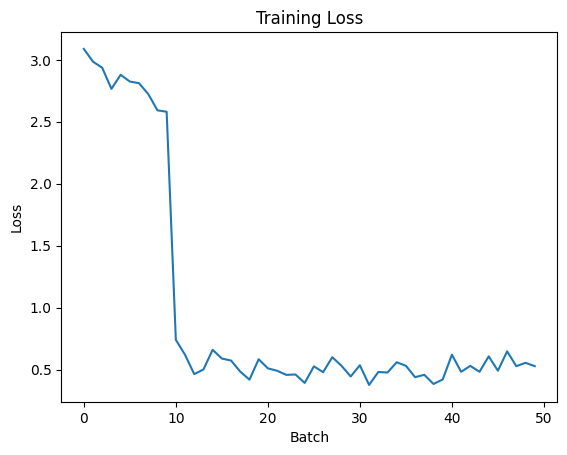

Loss: 0.5023231506347656
Loss: 0.43112683296203613
Loss: 0.4500785171985626
Loss: 0.4447336792945862
Loss: 0.443726122379303
Loss: 0.54666668176651
Loss: 0.5417488217353821
Loss: 0.5881993770599365
Loss: 0.5324769020080566
Loss: 0.5087855458259583
Loss: 0.6167880892753601
Loss: 0.490256667137146
Loss: 0.49715307354927063
Loss: 0.5122002959251404
Loss: 0.44845426082611084
Loss: 0.5797017216682434
Loss: 0.40687862038612366
Loss: 0.4046895205974579
Loss: 0.46629711985588074
Loss: 0.3434603214263916


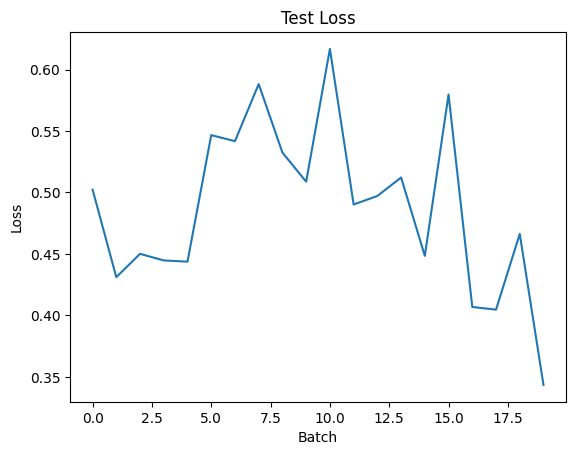

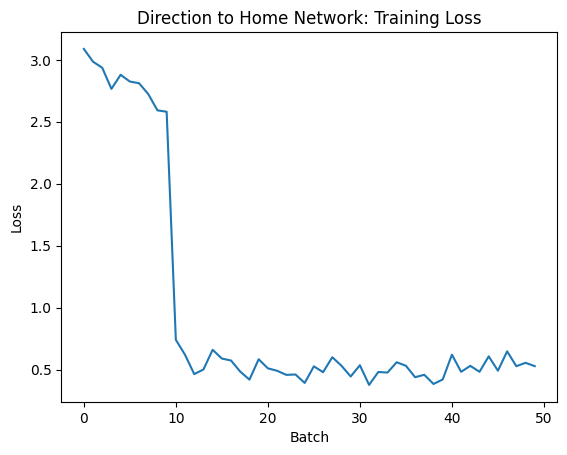

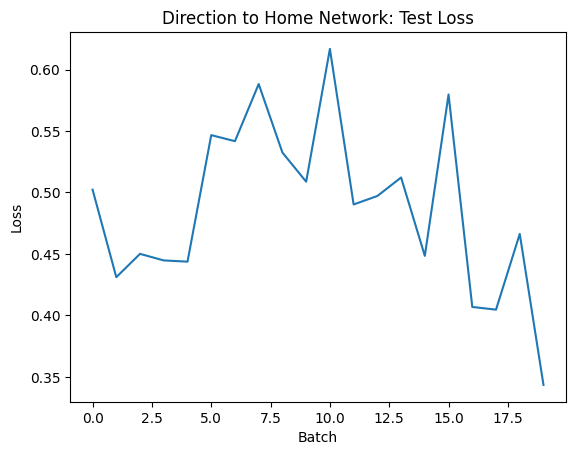

In [19]:
best_dataset = datasets[4] # Dataset with 100000 itmems
print(len(best_dataset[1][1]))

## We load dataset into a dataloader

images = best_dataset[1][2]  # Extracting the magnetic field images
strengths = best_dataset[1][3]  # Extracting the magnetic field strengths
theta_labels = best_dataset[1][4]  # Extracting the turn to home thetas
bird_magnetoreception_data = [[m1, m2, m3, strength] for (m1, m2, m3), strength in zip(images, strengths)] # Creating the combined input tensor

X = torch.tensor(bird_magnetoreception_data, dtype=torch.float32) # Convert to a PyTorch tensor
Y = [theta for theta in theta_labels] # Turn to home thetas in radians from the positive x-axis
dataset = torch.utils.data.TensorDataset(torch.Tensor(X),torch.Tensor(Y)) # create your datset

train_dataset, test_dataset = torch.utils.data.random_split(dataset,[0.8,0.2])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1000, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=True)

## Create the network
Magnetoreception_network = Net(input_size=4, hidden_size=200, depth=3, output_size=1)

## Train the network
network_results = train_network(Magnetoreception_network, train_loader_data=train_loader, num_epochs=5, learning_rate=0.0001)
network_trained = network_results[0]
training_loss = network_results[1]

## Test the network
test_loss = test_network(network_trained, test_loader)

## Plot the test and traring losses
plt.figure()
plt.plot(training_loss)
plt.title('Direction to Home Network: Training Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.show()

plt.figure()
plt.plot(test_loss)
plt.title('Direction to Home Network: Test Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.show()

